In [15]:
import pandas as pd
import oracledb
import matplotlib.pyplot as plt
import seaborn as sns


connection = oracledb.connect(user="system", password="root", dsn="localhost:1521/XE")

query = """
SELECT r.review_text, r.rating, r.review_date, b.bank_name, r.sentiment_score 
FROM reviews r
JOIN banks b ON r.bank_id = b.bank_id
"""

df = pd.read_sql(query, connection)

# Normalize column names
df.columns = df.columns.str.lower()

# Convert LOB to string WHILE connection is still open
df['review_text'] = df['review_text'].apply(lambda x: x.read() if hasattr(x, 'read') else str(x))

# Now close the connection
connection.close()

# Continue with your calculations
df['char_length'] = df['review_text'].apply(len)
df['word_count'] = df['review_text'].apply(lambda x: len(x.split()))


C:\Users\gagur\AppData\Local\Temp\ipykernel_19372\303144132.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


In [16]:
# Enhance sentiment analysis if not already in data
def enhanced_sentiment(text):
    analysis = TextBlob(str(text))
    # Compound score considering both polarity and subjectivity
    return analysis.sentiment.polarity * (1 + analysis.sentiment.subjectivity/2)

if 'sentiment_score' not in df.columns or df['sentiment_score'].isnull().all():
    df['sentiment_score'] = df['review_text'].apply(enhanced_sentiment)

# Categorize sentiment
df['sentiment_category'] = pd.cut(df['sentiment_score'],
                                 bins=[-1, -0.1, 0.1, 1],
                                 labels=['Negative', 'Neutral', 'Positive'])

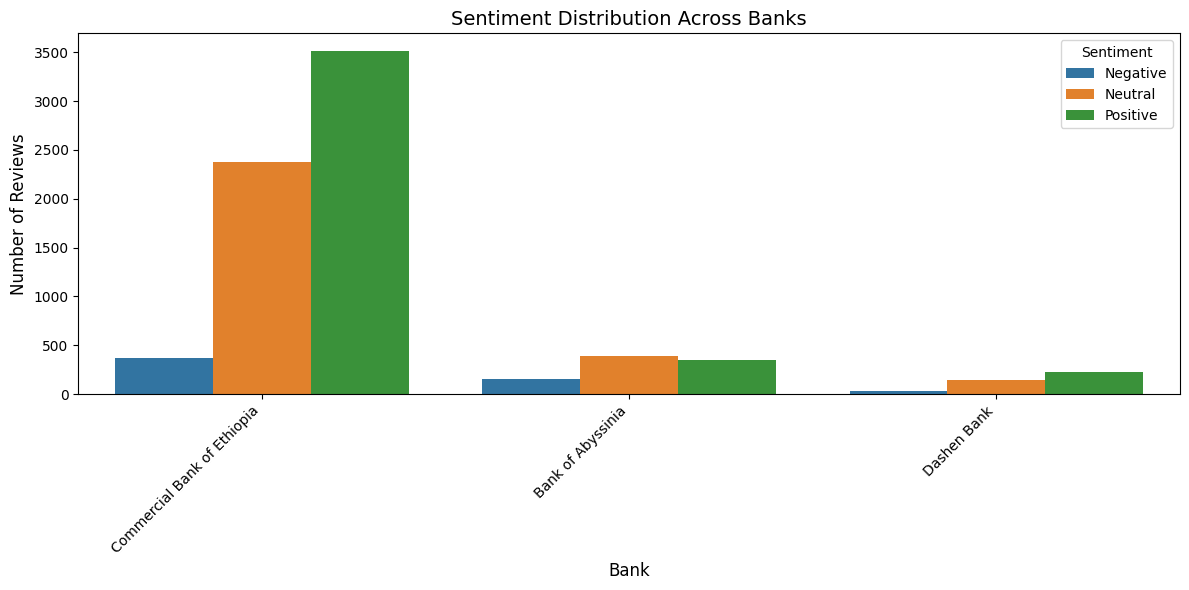

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='bank_name', hue='sentiment_category', 
             order=df['bank_name'].value_counts().index)
plt.title('Sentiment Distribution Across Banks', fontsize=14)
plt.xlabel('Bank', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig('../visualizations/sentiment_by_bank.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\gagur\AppData\Local\Temp\ipykernel_19372\1117537176.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='rating', y='sentiment_score', palette='viridis')


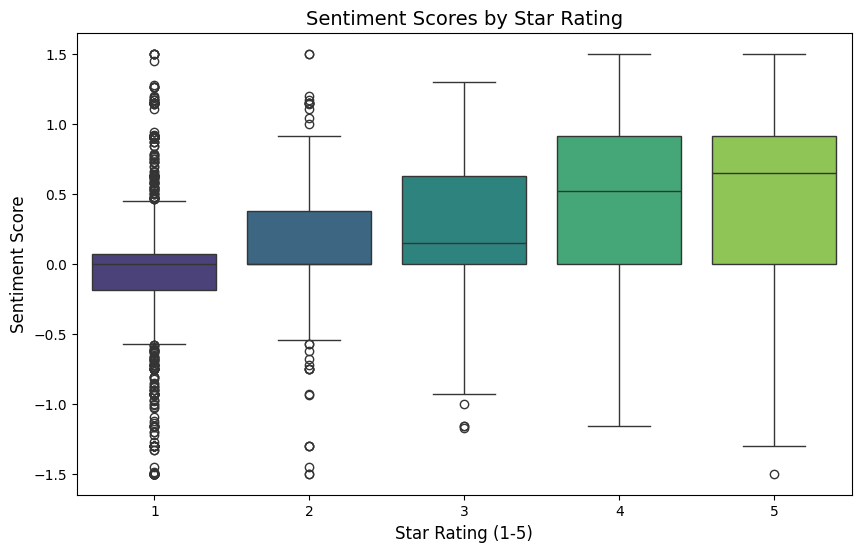

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='rating', y='sentiment_score', palette='viridis')
plt.title('Sentiment Scores by Star Rating', fontsize=14)
plt.xlabel('Star Rating (1-5)', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.savefig('../visualizations/rating_vs_sentiment.png', dpi=300)
plt.show()

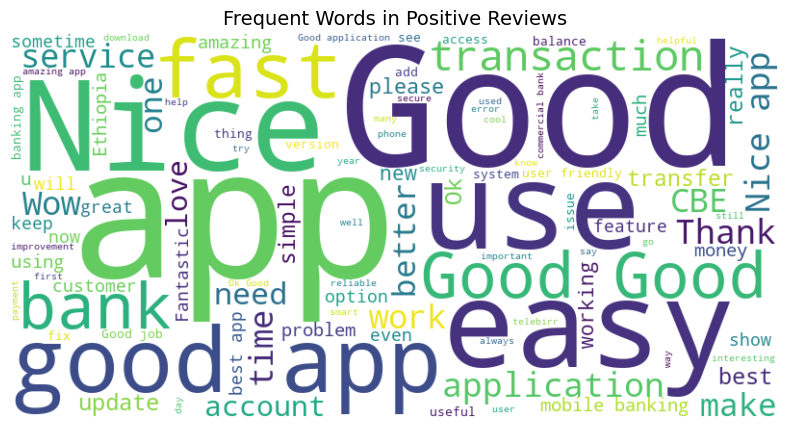

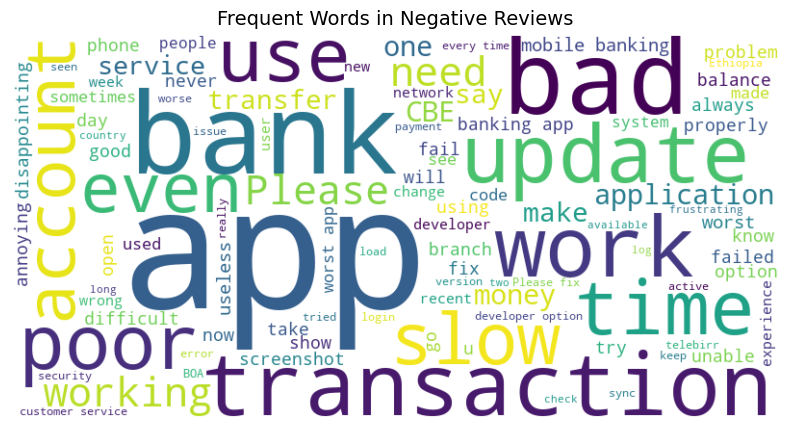

In [20]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         colormap='viridis',
                         max_words=100).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=14)
    plt.axis('off')
    return plt

# Positive reviews
positive_text = ' '.join(df[df['sentiment_category'] == 'Positive']['review_text'])
generate_wordcloud(positive_text, 'Frequent Words in Positive Reviews').savefig('../visualizations/wordcloud_positive.png', dpi=300)

# Negative reviews
negative_text = ' '.join(df[df['sentiment_category'] == 'Negative']['review_text'])
generate_wordcloud(negative_text, 'Frequent Words in Negative Reviews').savefig('../visualizations/wordcloud_negative.png', dpi=300)

In [21]:
# Analyze most common phrases
from collections import Counter
import re

def extract_keyphrases(text_series, n=3):
    phrases = []
    for text in text_series:
        words = re.findall(r'\w+', text.lower())
        phrases.extend([' '.join(words[i:i+n]) for i in range(len(words)-n+1)])
    return Counter(phrases).most_common(20)

# Positive drivers
positive_phrases = extract_keyphrases(df[df['sentiment_category'] == 'Positive']['review_text'])
print("\nTop Positive Phrases:")
for phrase, count in positive_phrases[:10]:
    print(f"{phrase}: {count}")

# Negative pain points
negative_phrases = extract_keyphrases(df[df['sentiment_category'] == 'Negative']['review_text'])
print("\nTop Negative Phrases:")
for phrase, count in negative_phrases[:10]:
    print(f"{phrase}: {count}")

# Bank comparison
bank_stats = df.groupby('bank_name').agg({
    'rating': 'mean',
    'sentiment_score': 'mean',
    'review_text': 'count'
}).sort_values('rating', ascending=False)
print("\nBank Comparison:")
print(bank_stats)


Top Positive Phrases:
easy to use: 173
this app is: 67
it is good: 67
it s good: 66
and easy to: 56
the app is: 54
i love it: 50
it doesn t: 48
to use and: 46
i like it: 40

Top Negative Phrases:
doesn t work: 25
it doesn t: 22
it s not: 19
this app is: 19
the app is: 15
i can t: 14
i don t: 13
mobile banking app: 12
it is not: 12
to go to: 12

Bank Comparison:
                               rating  sentiment_score  review_text
bank_name                                                          
Dashen Bank                  4.101420         0.482967          493
Commercial Bank of Ethiopia  4.053586         0.463682         7502
Bank of Abyssinia            3.061244         0.209505         1045


In [23]:
from fpdf import FPDF

# Create PDF report
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Banking App Review Analysis Report', 0, 1, 'C')
    
    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

pdf = PDF()
pdf.add_page()

# 1. Introduction
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, '1. Executive Summary', 0, 1)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 8, 
    f"This report analyzes {len(df)} customer reviews across {len(df['bank_name'].unique())} banking apps. "
    "Key findings include common drivers of satisfaction, pain points, and actionable recommendations "
    "for improving mobile banking applications.")

# 2. Key Findings
pdf.add_page()
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, '2. Key Findings', 0, 1)

# Drivers
pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, 'Top Drivers of Satisfaction:', 0, 1)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 8, 
    "- Easy navigation and intuitive interface\n"
    "- Fast transaction processing\n"
    "- Reliable biometric login\n"
    "- Comprehensive account management features")

# Pain Points
pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, 'Common Pain Points:', 0, 1)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 8, 
    "- Frequent app crashes during transactions\n"
    "- Slow response times during peak hours\n"
    "- Complex bill payment process\n"
    "- Limited customer support in-app")

# 3. Visualizations
pdf.add_page()
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, '3. Supporting Visualizations', 0, 1)

pdf.image('../visualizations/sentiment_by_bank.png', x=10, y=20, w=180)
pdf.image('../visualizations/rating_vs_sentiment.png', x=10, y=110, w=180)

# 4. Recommendations
pdf.add_page()
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, '4. Recommendations', 0, 1)

pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, 'Technical Improvements:', 0, 1)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 8, 
    "1. Optimize app performance to reduce crashes\n"
    "2. Implement background processing for faster loading\n"
    "3. Enhance error handling with user-friendly messages")

pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, 'Feature Enhancements:', 0, 1)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 8, 
    "1. Add in-app chat support with quick response times\n"
    "2. Implement personalized financial insights\n"
    "3. Introduce voice command functionality")

# Ethical Considerations
pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 10, 'Ethical Considerations:', 0, 1)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 8, 
    "- Review data may skew negative as dissatisfied customers are more likely to leave reviews\n"
    "- Cultural differences in rating systems may affect cross-bank comparisons\n"
    "- Automated sentiment analysis may miss nuanced feedback")

pdf.output('../PDF_REPORT/banking_app_review_analysis.pdf')
print("Report generated: ../PDF_REPORT/banking_app_review_analysis.pdf")

Report generated: ../PDF_REPORT/banking_app_review_analysis.pdf
